##Library Imports & Setup

In [ ]:
!pip install medmnist

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, DermaMNIST
import numpy as np
import matplotlib.pyplot as plt

##Data Loading & Basic Visualization

In [3]:
# Load all three splits
train_data = DermaMNIST(split='train', download=True)
val_data = DermaMNIST(split='val', download=True)
test_data = DermaMNIST(split='test', download=True)

# Print the size of each to confirm they loaded
print(f"Train samples: {len(train_data)}")
print(f"Val samples:   {len(val_data)}")
print(f"Test samples:  {len(test_data)}")


Train samples: 7007
Val samples:   1003
Test samples:  2005


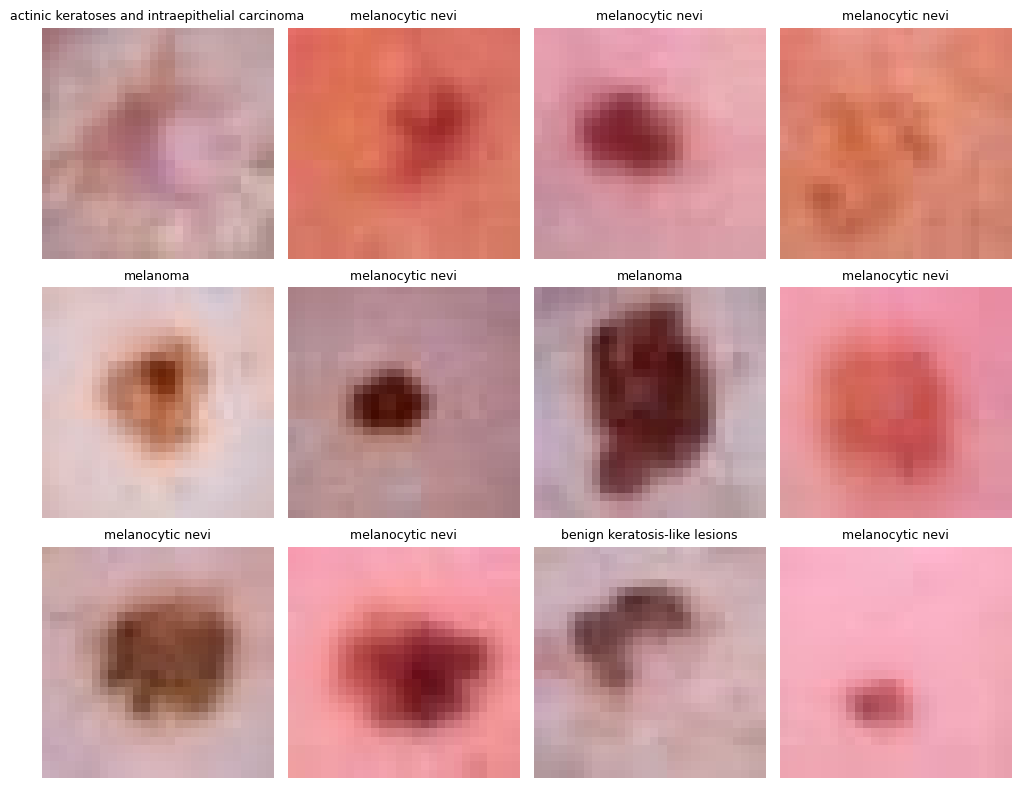

In [4]:
import matplotlib.pyplot as plt
from medmnist import INFO

# Get the label names (e.g., 'melanoma', 'basal cell carcinoma')
info = INFO['dermamnist']
label_names = info['label']

# Plot a grid of images
plt.figure(figsize=(10, 8))

for i in range(12):
    # Get image and label index
    img, label = train_data[i]

    # Create a subplot for each image
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)

    # Get the actual name of the disease from the label index
    label_text = label_names[str(label[0])]
    plt.title(label_text, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


#Intro to Data Transformations

In [5]:
# from torchvision import transforms

# # This is the "Everything Bagel" of transforms.
# # It applies every single effect we discussed in sequence.
# learning_transforms = transforms.Compose([

#     # --- 1. RESIZING & SHAPE ---
#     # Makes the tiny 28x28 image larger (64x64). Good for seeing details.
#     transforms.Resize((64, 64)),

#     # --- 2. RANDOM FLIPS ---
#     # 50% chance to flip horizontally (mirror) or vertically (upside down).
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),

#     # --- 3. ROTATION ---
#     # Spins the image randomly anywhere between -45 and +45 degrees.
#     transforms.RandomRotation(degrees=45),

#     # --- 4. COLOR & LIGHTING (JITTER) ---
#     # Randomly changes Brightness, Contrast, Saturation, and Hue by up to 20%.
#     # This is the "Jitter" that simulates different cameras/lighting.
#     transforms.ColorJitter(brightness=0.9, contrast=0.2, saturation=0.2, hue=0.1),

#     # --- 5. STYLE & BLUR ---
#     # Turns it Black & White (but keeps 3 channels so the model doesn't crash).
#     transforms.Grayscale(num_output_channels=3),

#     # Blurs the image slightly (like a shaky hand holding a camera).
#     transforms.GaussianBlur(kernel_size=3),

#     # --- 6. CROPPING ---
#     # Zooms in and grabs a random 50x50 area from the resized 64x64 image.
#     transforms.RandomCrop(50),

#     # --- 7. THE MATH (MANDATORY) ---
#     # Converts the edited picture into a Tensor (math grid) for the computer.
#     transforms.ToTensor(),

#     # Centers all the pixel math around zero so the CNN trains faster.
#     transforms.Normalize(mean=[0.5], std=[0.5])
# ])


In [6]:
# from PIL import Image
# import numpy as np

# plt.figure(figsize=(12, 10))

# for i in range(12):
#     # 1. Get the raw numpy array from medmnist
#     raw_array = train_dataset.imgs[i]

#     # 2. FIX: Convert the numpy array to a PIL Image first
#     # This is what transforms.Resize and others expect!
#     pil_img = Image.fromarray(raw_array)

#     # 3. Apply your math transforms
#     math_img = learning_transforms(pil_img)

#     plt.subplot(3, 4, i + 1)

#     # Use our previous helper to show the math
#     # (Un-normalizes and permutes channels)
#     imshow_math(math_img)

#     # Get labels (squeeze() is used because medmnist labels are 2D arrays)
#     label_idx = train_dataset.labels[i].item()
#     label_text = info['label'][str(label_idx)]

#     plt.title(label_text, fontsize=8)
#     plt.axis('off')

# plt.tight_layout()
# plt.show()



# Experimental Baseline Configuration
### Testing different Models (linear, mlp, cnn, resnet, and vit) to establish the best one

In [7]:
#basic dataloading and setups

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [6]:
data_flag = 'pathmnist'
info = INFO[data_flag]
num_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = DataClass(split='train', transform=transform, download=True)
val_dataset = DataClass(split='val', transform=transform, download=True)
test_dataset = DataClass(split='test', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)


In [10]:
#training and eval

In [7]:
def train_model(model, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.squeeze().long().to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


In [8]:
def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.squeeze().long().to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total


##Baseline Models

In [13]:
#linear model

A linear model is the simplest approach/visualization. It takes the image and transforms it into a long list of pixel values by flattening into a 1-demensional vector. The model learns this single linear equation by combining all the pixel values to produce a prediction. It can only capture basic patterns like brightness and colors, not shapes or edges or anything. This causes linear models to perform poorly overall, but are a good baseline.

In [14]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28*3, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [15]:
model_linear = LinearModel().to(device)
optimizer = optim.Adam(model_linear.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_model(model_linear, optimizer, criterion)
acc_linear = evaluate_model(model_linear)
print("Linear Accuracy:", acc_linear)


Epoch 1/10, Loss: 1.9313
Epoch 2/10, Loss: 1.8345
Epoch 3/10, Loss: 1.8145
Epoch 4/10, Loss: 1.8000
Epoch 5/10, Loss: 1.7862
Epoch 6/10, Loss: 1.7812
Epoch 7/10, Loss: 1.7793
Epoch 8/10, Loss: 1.7708
Epoch 9/10, Loss: 1.7621
Epoch 10/10, Loss: 1.7609


KeyboardInterrupt: 

In [ ]:
#MLP

MLP means multi-layer perceptron and its a little bit more advanced than a linear model but pretty similar overall. Similar to a linear model, it takes the images and flattens them, but it is able to learn more complex pixels. It can capture nonlinear patterns that linear can't, but still struggles with images and can't correlate nearby pixels with eachother.

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28*3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


In [ ]:
model_mlp = MLP().to(device)
optimizer = optim.Adam(model_mlp.parameters(), lr=1e-3)

train_model(model_mlp, optimizer, criterion)
acc_mlp = evaluate_model(model_mlp)
print("MLP Accuracy:", acc_mlp)


In [ ]:
#CNN - classic baseline model

Stands for convolutional nueral network, it is a classic model for being able to understand images in the forms of pixels. Instead of flattening the pixels, it keeps them 2-dimensional. How it works: it uses small filters to slide across the images and detect patters like edges, corners, and textures. All these layers are then combined across layers to form more advanced representations of shapes/objects. Since filters cover the full image, the model is good at recognizing objects regardless of where they are (unlike linear and mlp), which means its way more effective.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(64 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [ ]:
model_cnn = SimpleCNN().to(device)
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

train_model(model_cnn, optimizer, criterion)
acc_cnn = evaluate_model(model_cnn)
print("CNN Accuracy:", acc_cnn)


In [ ]:
#ResNet

Stands for residual network, and is a more powerful version of cnn. Some network models have issues with training due to vanishing gradients, and resnet solves this by using skip connections. It allows information to bypass certain layers. It helps the model learn and stabalize training, even when theres a lot of layers. As a result, resnet can learn very detailed images and are even stronger than cnn.

In [ ]:
from torchvision.models import resnet18

model_resnet = resnet18(pretrained=False)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)
model_resnet = model_resnet.to(device)


In [ ]:
optimizer = optim.Adam(model_resnet.parameters(), lr=1e-3)

train_model(model_resnet, optimizer, criterion)
acc_resnet = evaluate_model(model_resnet)
print("ResNet Accuracy:", acc_resnet)


In [ ]:
#ViT

Stands for Vision Transformer, and it takes a completly different approach then cnn and resnet. Instead of looking at local pixels it divides the image into patches and treats each patch as a token (like words in a sentence). Then it allows every patch to interact with eachother giving the model a strong ability to model gloabl relationships across the entire image. Since they are so advanced, they require large amounts of data/pretraining to perform well. Not as good for smaller datasets like cnn and resnet would be.

In [ ]:
import timm

model_vit = timm.create_model(
    'vit_tiny_patch16_224',
    pretrained=False,
    num_classes=num_classes
)
model_vit = model_vit.to(device)


In [ ]:
#needs to reshape images for ViT to 224x224
transform_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
train_dataset.transform = transform_vit
test_dataset.transform = transform_vit


In [ ]:
optimizer = optim.Adam(model_vit.parameters(), lr=3e-4)

train_model(model_vit, optimizer, criterion)
acc_vit = evaluate_model(model_vit)
print("ViT Accuracy:", acc_vit)


### Compare Models

In [ ]:
results = {
    "Linear": acc_linear,
    "MLP": acc_mlp,
    "CNN": acc_cnn,
    "ResNet": acc_resnet,
    "ViT": acc_vit
}

for k, v in results.items():
    print(f"{k}: {v:.4f}")


#Autoencoder Model

- In the MedMNIST dataset, the autoencoder learns to compress 28×28 medical images by retaining essential features such as edges and shapes in a latent representation, and then reconstructs the original image, producing outputs that closely resemble the input but are slightly smoother due to compression.

In [9]:
# Startby defining greyscale, images where originally 3-output
ae_transform = transforms.Compose([
    transforms.ToTensor()   # keeps RGB if the image is RGB
])


In [10]:
# Create a new dataset for the encoder
ae_train_dataset = DermaMNIST(
    split="train",
    transform=ae_transform,
    download=True
)

ae_train_loader = DataLoader(
    ae_train_dataset,
    batch_size=128,
    shuffle=True
)

In [11]:
# Define a Convolutional Autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # -------- ENCODER --------
        # Input: (batch_size, 3, 28, 28)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # -------- DECODER --------
        # Output: (batch_size, 3, 28, 28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2,
                               padding=1, output_padding=1),
            nn.Sigmoid()  # keeps output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
#initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder = ConvAutoencoder().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [13]:
# training loop
num_epochs = 10

for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0

    for images, _ in ae_train_loader:
        images = images.to(device)

        outputs = autoencoder(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(ae_train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 0.0375
Epoch [2/10], Loss: 0.0143
Epoch [3/10], Loss: 0.0067
Epoch [4/10], Loss: 0.0039
Epoch [5/10], Loss: 0.0027
Epoch [6/10], Loss: 0.0022
Epoch [7/10], Loss: 0.0020
Epoch [8/10], Loss: 0.0018
Epoch [9/10], Loss: 0.0017
Epoch [10/10], Loss: 0.0016


images min/max: 0.0 1.0
recon min/max: 0.07318658381700516 0.9534498453140259


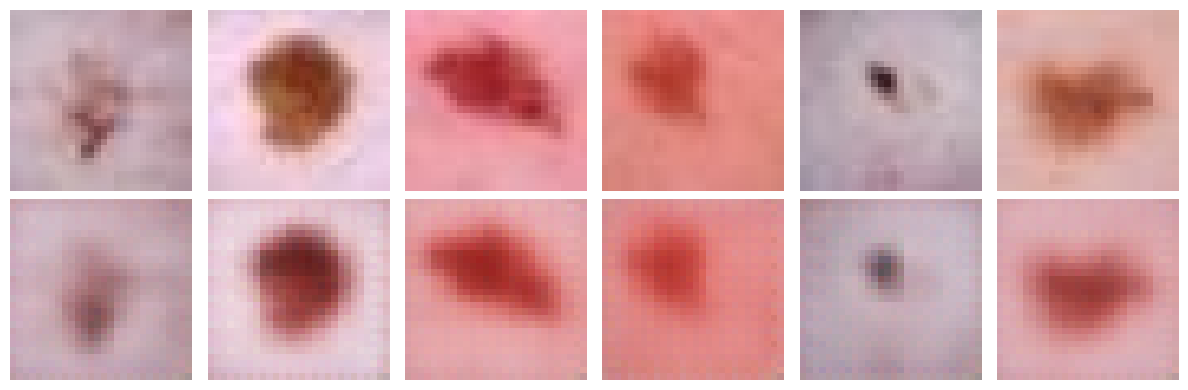

In [16]:
#visualize original versus reconstructed
autoencoder.eval()

with torch.no_grad():
    images, _ = next(iter(ae_train_loader))
    images = images.to(device)
    reconstructed = autoencoder(images)

images = images.cpu()
reconstructed = reconstructed.cpu()

# Quick sanity check: min/max
print("images min/max:", images.min().item(), images.max().item())
print("recon min/max:", reconstructed.min().item(), reconstructed.max().item())

num_images = 6
fig, axes = plt.subplots(2, num_images, figsize=(12, 4))

for i in range(num_images):
    # Original RGB
    axes[0, i].imshow(images[i].permute(1, 2, 0))
    axes[0, i].axis("off")

    # Reconstructed RGB
    axes[1, i].imshow(reconstructed[i].permute(1, 2, 0).clamp(0, 1))
    axes[1, i].axis("off")

axes[0, 0].set_ylabel("Original", fontsize=12)
axes[1, 0].set_ylabel("Reconstructed", fontsize=12)

plt.tight_layout()
plt.show()


- The autoencoder takes an input image, compresses it into a smaller latent representation, and then reconstructs it back to its original form. The top row shows the original images from the dataset, and the bottom row shows the reconstructed outputs produced by the autoencoder. Since the reconstructed images look very similar to the originals, this indicates that the autoencoder has successfully learned meaningful features of the data. Small differences, such as slight blurring or missing fine details, are normal because the model compresses information in the latent space, capturing the overall structure rather than every pixel perfectly.

- Next steps would be a diffusion model. Its like the opposite of a decoder, it adds noise to the images and then denoises them to produce real samples.

#Diffusion Model
- Its like the opposite of a decoder, it adds noise to the images and then denoises them to produce real samples.

In [20]:
# TRAINING A DENOISING AUTOENCODER
# This snippet trains the autoencoder to remove Gaussian noise from images.

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- Hyperparameters ---
num_epochs = 10
learning_rate = 1e-3
noise_std = 0.1  # standard deviation of Gaussian noise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Loss and optimizer ---
mse = nn.MSELoss()
l1 = nn.L1Loss()

for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0

    for images, _ in ae_train_loader:
        images = images.to(device)

        noisy_images = images + noise_std * torch.randn_like(images)
        noisy_images = torch.clamp(noisy_images, 0, 1)

        outputs = autoencoder(noisy_images)

        loss = 0.5*mse(outputs, images) + 0.5*l1(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(ae_train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")



Epoch [1/10], Loss: 0.0245
Epoch [2/10], Loss: 0.0154
Epoch [3/10], Loss: 0.0150
Epoch [4/10], Loss: 0.0147
Epoch [5/10], Loss: 0.0144
Epoch [6/10], Loss: 0.0143
Epoch [7/10], Loss: 0.0141
Epoch [8/10], Loss: 0.0140
Epoch [9/10], Loss: 0.0138
Epoch [10/10], Loss: 0.0138


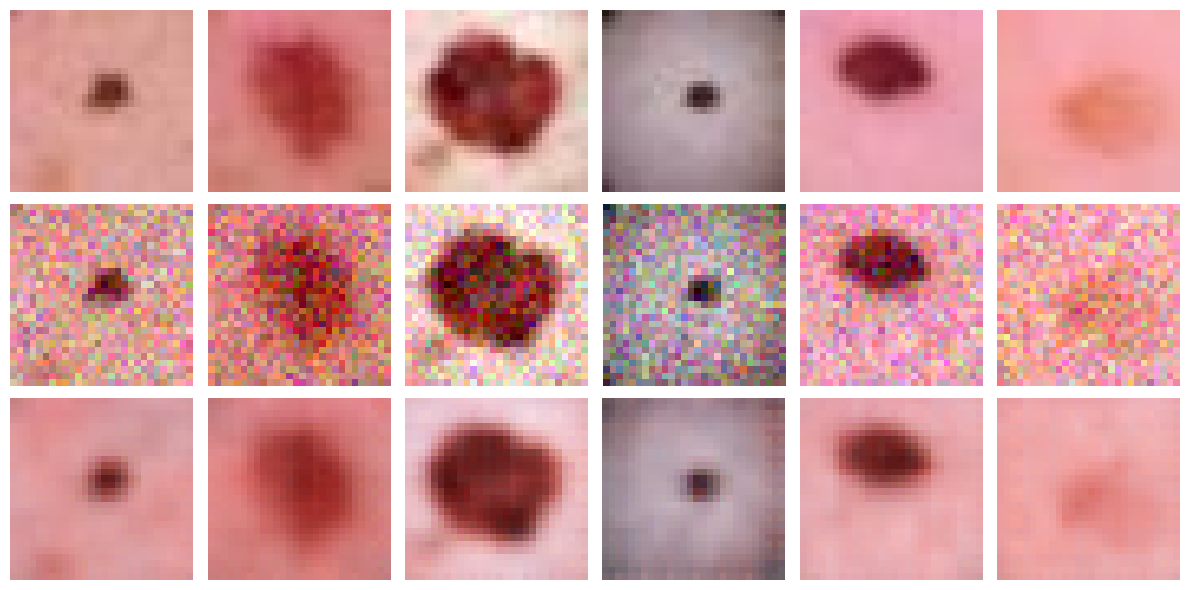

In [21]:
# VISUALIZE ORIGINAL, NOISY, AND DENOISED IMAGES
# This snippet shows a comparison of original images, their noisy versions, and the autoencoder reconstructions.

# Evaluate the model on one batch
autoencoder.eval()
with torch.no_grad():
    images, _ = next(iter(ae_train_loader))
    images = images.to(device)

    # Add Gaussian noise
    noisy_images = images + noise_std * torch.randn_like(images)
    noisy_images = torch.clamp(noisy_images, 0, 1)

    # Denoise using autoencoder
    reconstructed = autoencoder(noisy_images)

# Move tensors to CPU for plotting
images = images.cpu()
noisy_images = noisy_images.cpu()
reconstructed = reconstructed.cpu()

# Extra safety clamp
images = images.clamp(0, 1)
noisy_images = noisy_images.clamp(0, 1)
reconstructed = reconstructed.clamp(0, 1)

# Plot a comparison: Original → Noisy → Denoised (RGB)
num_images = 6
fig, axes = plt.subplots(3, num_images, figsize=(12, 6))

for i in range(num_images):
    axes[0, i].imshow(images[i].permute(1, 2, 0))
    axes[0, i].axis("off")

    axes[1, i].imshow(noisy_images[i].permute(1, 2, 0))
    axes[1, i].axis("off")

    axes[2, i].imshow(reconstructed[i].permute(1, 2, 0))
    axes[2, i].axis("off")

axes[0, 0].set_ylabel("Original", fontsize=12)
axes[1, 0].set_ylabel("Noisy", fontsize=12)
axes[2, 0].set_ylabel("Denoised", fontsize=12)

plt.tight_layout()
plt.show()



So the model shows the original images, the noisy images, and then the denoised images. What we can see is that the model successfully learned to reduce the noise and blur, because the outputs where smoother and more similar to the original images. However, even though the sharpness improved, the images where alittle off on color. This is common in images, especially skin images like the derma dataset that was used. This is because skin tone has subtle gradients and variations that is hard for the model to follow. This can also be happening because the images are small (28x28), meaning theres not alot of pixels to work with.